20240227

SarahFong

Take output from DiffBind summarized peak and count matrix and prepare data for 
1. Clean diffbind normalized count data (remove bad coordinates)
2. perform PCA on ATAC read count data. 

In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt

from scipy import stats
from scipy.stats import zscore, boxcox

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# load data

In [2]:
sns.__version__

'0.13.2'

In [3]:
PATH = "/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results"
os.chdir(PATH)
RE = "/wynton/group/ahituv/fongsl/projects/US/results/ATAC/diffbind_deseq"

# functions

## clean bed

In [4]:
def cleanBed(file):

    # name of the outfile
    outfile = ".".join(file.split('.')[:-1]) + ".cleaned.bed"

    # python command for cleaning bed file
    cmd = ' '.join([
        "python", 
        "/wynton/home/ahituv/fongsl/tools/genome/bed_clean.py",  # custom script that removes bad coordinates (start>end, start<0)
        file
    ])

    if os.path.exists(outfile) is False:  # if not already cleaned
        os.system(cmd)  # execute command
    else:
        print("already made?", outfile)

    return outfile

## compute replicate mean, peak centers

## count pbt obj lines

In [5]:
def pbtCounter(pbt_obj):
    """count lines in pybedtool object, return count"""
    
    v = 0
    for i in pbt_obj:
        v+=1
    
    #print(v)
    
    return v

## label elements w/ names

In [6]:
def labelDf(df, label_name, label_value):
    """add an indexed label to dataframe"""
    df["label"]= label_value
    df[label_name]=label_value + "." + df.index.map(str)
    
    return df

## make fa into pd.df

In [7]:
def fastaDf(file):
    """ turn fasta file into pd dataframe"""

    fasta_df = {}
    print(file)
    
    # parse open fasta file
    with open(file, "r") as reader:
        for value in SimpleFastaParser(reader):
            seqid, seq = value
            fasta_df[seqid] = seq
            
    # make dataframe
    df = pd.DataFrame(fasta_df.items())

    # name columns
    df.columns = ["seq.id", "seq"]
    return df

## make chromosome list

In [8]:
def chrList():
    """return  list of chromosomes"""
    
    chrs = []
    
    for n in np.arange(1,23):
        chrs.append(f"chr{n}")
    
    # add sex chromosomes
    chrs.append("chrX")
    chrs.append("chrY")
    
    return chrs

def filterConc(df, min_conc, col1, col2):
    print("before filter shape", df.shape)
    filtered = df.loc[(df[col1]>=min_conc)| 
                      (df[col2]>=min_conc) 
                     ].drop_duplicates().copy()
    
    print("after filter shape", filtered.shape)
    return filtered

def zscore(df, col):
    """compute z-score for a column"""
    df[f'{col}.zscore'] = (df[col] - df[col].mean())/df[col].std()
    
    return df


In [9]:
def plotHist(df, fdf, CL):
    fig, ax= plt.subplots(figsize=(6,6))
    sns.histplot(x="Conc_Ultrasound", data=df, label="unfiltered")
    sns.histplot(x="Conc_Ultrasound", data=fdf, label="filtered")
    ax.set(title=CL)
    ax.legend()

In [10]:
def encodeIntersection(cl, fdf, dif_bed, min_conc, count_all, count_diff):

    ENCODE_CCREs = {'hepg2': "/wynton/group/ahituv/data/encode/hepg2",
                    "k562": "/wynton/group/ahituv/data/encode/k562",
                    "hob": "/wynton/group/ahituv/data/encode/MG63",  # imperfect match, human osteosarcoma - https://www.sigmaaldrich.com/US/en/product/sigma/cb_86051601?utm_source=google&utm_medium=cpc&utm_campaign=8906396346&utm_content=88453247983&gclid=Cj0KCQiArrCvBhCNARIsAOkAGcVymGqSXznvXF-1hmqzVx8mK0z7eopHlS356QdcjYOyInUuoAHrmHEaAvWHEALw_wcB
                    "bj": "/wynton/group/ahituv/data/encode/bj"
                    }

    ENCODE_PATH = ENCODE_CCREs[cl]
    annots = glob.glob(os.path.join(ENCODE_PATH, "*.bed"))

    d = pbt.BedTool(dif_bed)
    f = pbt.BedTool.from_dataframe(fdf)
    # evaluate the filtered diff accessible elements
    dxf = d.intersect(f, wa=True)

    fdf_count, fdifacc_count = pbtCounter(f), pbtCounter(dxf)

    reg_annots = ["CTCF-only,CTCF-bound",
                  "dELS",
                  "PLS,CTCF-bound",
                  "pELS",
                  "PLS", "pELS,CTCF-bound",
                  "dELS,CTCF-bound"]

    results = {}

    results["totals"] = [cl, "total.atac",
                         min_conc, None, fdf_count, fdifacc_count]

    for a in annots:

        annot = ((a.split("/")[-1]).split(".")[0])

        if annot in reg_annots:  # per annotation
            print("\n\n", cl,  annot)
            encode_bed = pbt.BedTool(a)
            encode_count = pbtCounter(encode_bed)

            result_count_vector = [cl, annot, min_conc, encode_count]

            for i in [f, dxf]:  # per dataset
                ixe = i.intersect(encode_bed, wa=True)
                result_count_vector.append(pbtCounter(ixe))

            results[annot] = result_count_vector

    colnames = ["cl", "annotation", "filter_minConc", "N_cCRE",
                f"N_filter.Acc",
                f"N_filter.DiffAcc",
                ]
    
    new_df = pd.DataFrame(results.values(), columns=colnames)
    
    # compute percent of all peaks in filtered set
    new_df["percent_allAcc"]= new_df["N_filter.Acc"]/count_all
    new_df["percent_DiffAcc"] = new_df["N_filter.DiffAcc"]/count_diff
    
    return new_df

# Main

## clean bed files, intersect with ENCODE

In [11]:
# params
MIN_CONCS= [0,1,2,3,4,5,6]
CLS =['hepg2', 'k562', "hob", "bj"]
COUNT_ALL, COUNT_DIFF =0,0
cl_results = {}
for CL in CLS:
    print(CL)

    ALL = f"{CL}_deseq2-nondiff.csv"
    ALL_BED = ALL.strip(".csv") + ".bed"

    # DESEQ2 diff acc
    DIFF = f"{CL}_deseq2.csv"
    DIFF_BED = DIFF.strip(".csv") + ".bed"

    DIFF_IN_ALL = f"{CL}_deseq2-nondiff.in.diffAcc.bed"

    df = pd.read_csv(ALL)
    df = df.loc[df["seqnames"].isin(chrList())] ## remove weird chromosomes, e.g. ChrUnXXX
    
    for MIN_CONC in MIN_CONCS:
        print("MIN_CONC", MIN_CONC)
        if MIN_CONC == 0:
            
            # get the totals count
            COUNT_ALL, COUNT_DIFF =  pbtCounter(pbt.BedTool(ALL_BED)),  pbtCounter(pbt.BedTool(DIFF_BED))
            fdf = df
        else:
            fdf = filterConc(df, MIN_CONC, "Conc_Ultrasound", "Conc_Control")
        
        #plotHist(df, fdf, CL)

        # intersect w/ encode
        cl_results[f"{CL}.{str(MIN_CONC)}"] = encodeIntersection(CL, fdf, DIFF_BED, MIN_CONC, COUNT_ALL, COUNT_DIFF)


hepg2
MIN_CONC 0


 hepg2 CTCF-only,CTCF-bound


 hepg2 dELS


 hepg2 PLS,CTCF-bound


 hepg2 pELS


 hepg2 PLS


 hepg2 pELS,CTCF-bound


 hepg2 dELS,CTCF-bound
MIN_CONC 1
before filter shape (127857, 11)
after filter shape (116859, 11)


 hepg2 CTCF-only,CTCF-bound


 hepg2 dELS


 hepg2 PLS,CTCF-bound


 hepg2 pELS


 hepg2 PLS


 hepg2 pELS,CTCF-bound


 hepg2 dELS,CTCF-bound
MIN_CONC 2
before filter shape (127857, 11)
after filter shape (82757, 11)


 hepg2 CTCF-only,CTCF-bound


 hepg2 dELS


 hepg2 PLS,CTCF-bound


 hepg2 pELS


 hepg2 PLS


 hepg2 pELS,CTCF-bound


 hepg2 dELS,CTCF-bound
MIN_CONC 3
before filter shape (127857, 11)
after filter shape (49249, 11)


 hepg2 CTCF-only,CTCF-bound


 hepg2 dELS


 hepg2 PLS,CTCF-bound


 hepg2 pELS


 hepg2 PLS


 hepg2 pELS,CTCF-bound


 hepg2 dELS,CTCF-bound
MIN_CONC 4
before filter shape (127857, 11)
after filter shape (27452, 11)


 hepg2 CTCF-only,CTCF-bound


 hepg2 dELS


 hepg2 PLS,CTCF-bound


 hepg2 pELS


 hepg2 PLS


 hepg

In [12]:
results = pd.concat(cl_results.values())

results.round(2)

cl            annotation  filter_minConc   N_cCRE  N_filter.Acc  \
0   hepg2            total.atac               0      NaN        127857   
1   hepg2  CTCF-only,CTCF-bound               0  20944.0         12332   
2   hepg2                  dELS               0  25435.0         15164   
3   hepg2        PLS,CTCF-bound               0   2377.0          2017   
4   hepg2                  pELS               0  16656.0          5931   
..    ...                   ...             ...      ...           ...   
1      bj        PLS,CTCF-bound               5   3835.0          2914   
2      bj                   PLS               5   9445.0          6403   
0      bj            total.atac               6      NaN         11283   
1      bj        PLS,CTCF-bound               6   3835.0          2040   
2      bj                   PLS               6   9445.0          4269   

    N_filter.DiffAcc  percent_allAcc  percent_DiffAcc  
0               1521            1.00             0.79  
1                183            0.10             0.10  
2                180            0.12             0.09  
3                 12            0.02             0.01  
4                 48            0.05             0.03  
..               ...             ...              ...  
1                 12            0.02             0.03  
2                 21            0.05             0.05  
0                 32            0.10             0.07  
1                  9            0.02             0.02  
2                 13            0.04             0.03  

[147 rows x 8 columns]

In [37]:
list(results)

['cl',
 'annotation',
 'filter_minConc',
 'N_cCRE',
 'N_filter.Acc',
 'N_filter.DiffAcc',
 'percent_allAcc',
 'percent_DiffAcc']

## any encode overlap per filter

In [42]:
cols = ['cl',
        'filter_minConc',
        'N_filter.Acc',
        'N_filter.DiffAcc',
        'percent_allAcc',
        'percent_DiffAcc']

# remove annotation, ncCRE, and get total percent of elements overlapping ANY encode annotation
any_encode = results.loc[results["annotation"] != "total.atac", cols].groupby(
    ["cl", "filter_minConc"]).sum().copy().reset_index()

In [43]:
any_encode

cl  filter_minConc  N_filter.Acc  N_filter.DiffAcc  percent_allAcc  \
0      bj               0         11115                35        0.094628   
1      bj               1         11115                35        0.094628   
2      bj               2         11092                35        0.094432   
3      bj               3         11010                35        0.093734   
4      bj               4         10649                35        0.090661   
5      bj               5          9317                33        0.079321   
6      bj               6          6309                22        0.053712   
7   hepg2               0         48935               528        0.381378   
8   hepg2               1         48825               528        0.380521   
9   hepg2               2         46200               518        0.360063   
10  hepg2               3         37538               444        0.292555   
11  hepg2               4         26780               294        0.208712   
12  hepg2               5         16260               114        0.126723   
13  hepg2               6          7390                29        0.057594   
14    hob               0         13636               567        0.085471   
15    hob               1         13636               567        0.085471   
16    hob               2         13634               567        0.085459   
17    hob               3         13560               567        0.084995   
18    hob               4         13242               567        0.083002   
19    hob               5         12465               560        0.078131   
20    hob               6         10841               542        0.067952   
21   k562               0         60173               344        0.585967   
22   k562               1         60173               344        0.585967   
23   k562               2         60154               344        0.585782   
24   k562               3         58317               340        0.567894   
25   k562               4         50190               285        0.488753   
26   k562               5         39332               202        0.383017   
27   k562               6         28633               131        0.278829   

    percent_DiffAcc  
0          0.080831  
1          0.080831  
2          0.080831  
3          0.080831  
4          0.080831  
5          0.076212  
6          0.050808  
7          0.275574  
8          0.275574  
9          0.270355  
10         0.231733  
11         0.153445  
12         0.059499  
13         0.015136  
14         0.243976  
15         0.243976  
16         0.243976  
17         0.243976  
18         0.243976  
19         0.240964  
20         0.233219  
21         0.386517  
22         0.386517  
23         0.386517  
24         0.382022  
25         0.320225  
26         0.226966  
27         0.147191

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

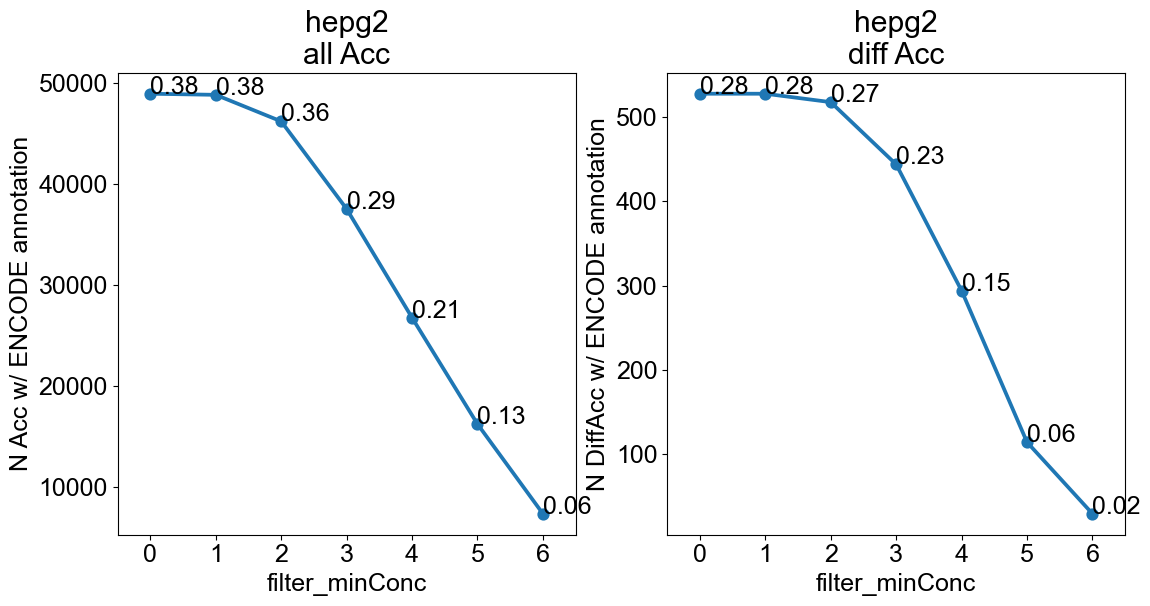

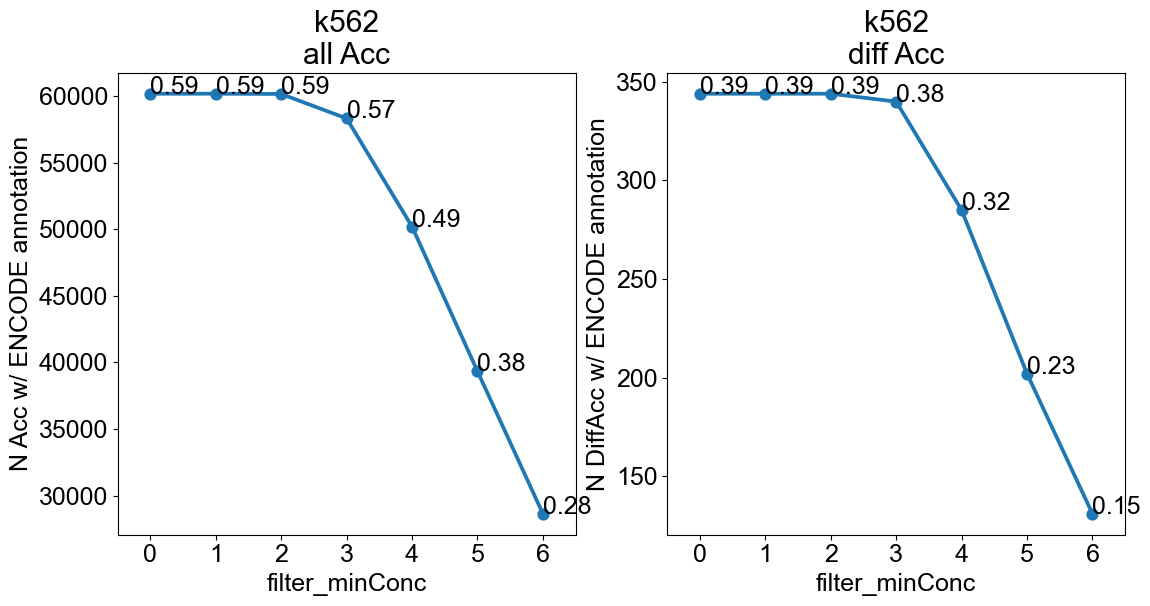

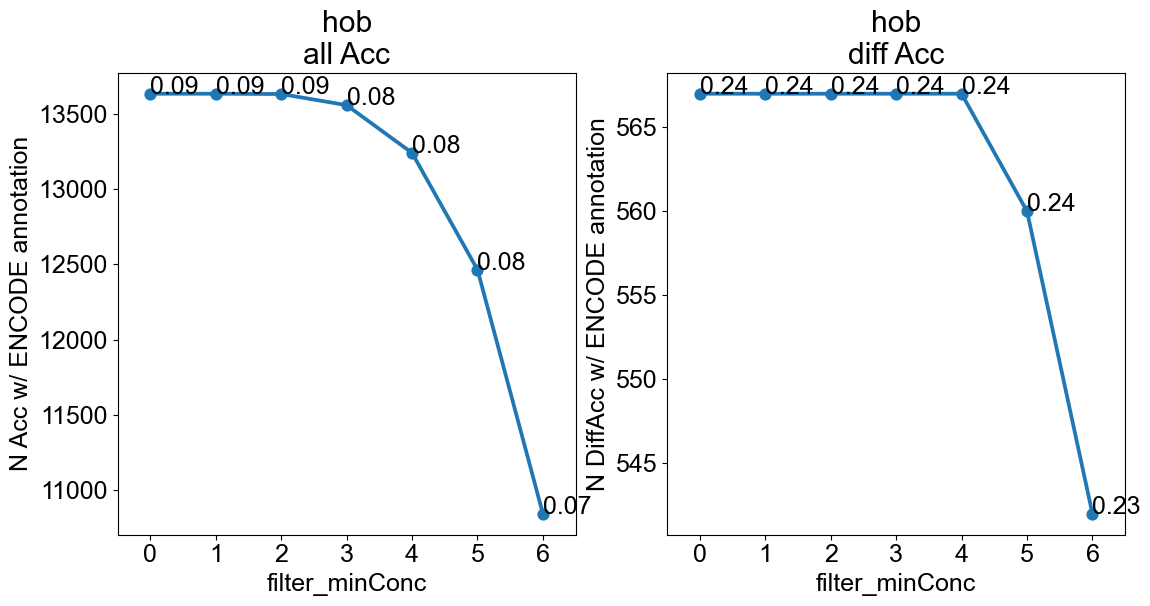

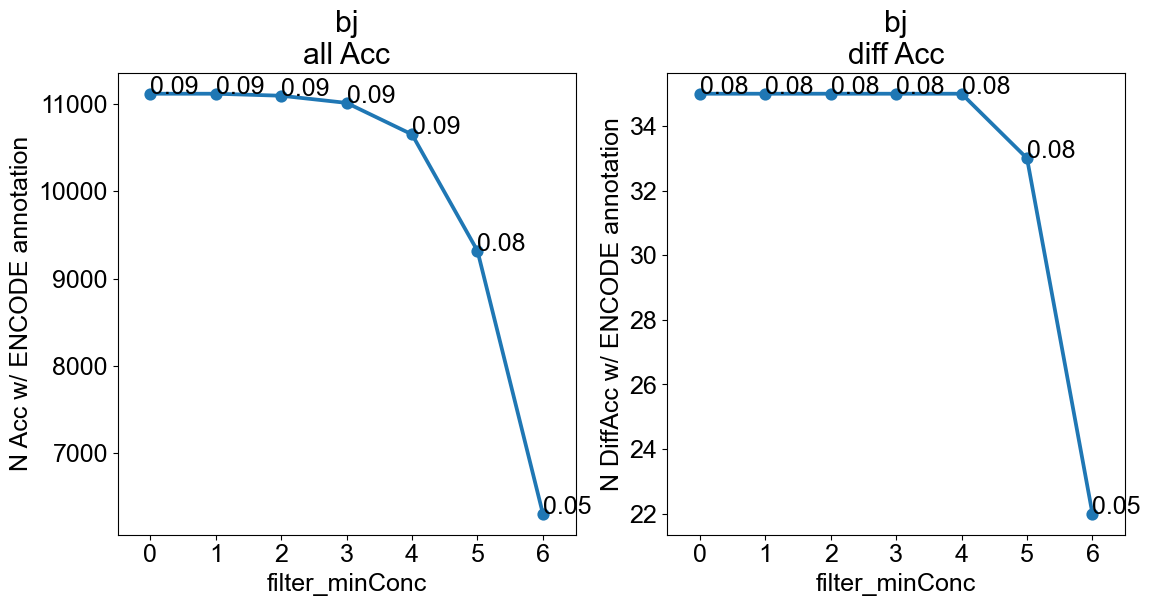

In [71]:
last1, last2 = 0,0
for CL in CLS:
    x = "filter_minConc"
    y = 'N_filter.Acc'
    
    data = any_encode.loc[any_encode["cl"] == CL]


    # plot
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 6))

    sns.pointplot(x=x, y=y, data=data,
                  ax=ax1)
    ax1.legend(frameon=False, bbox_to_anchor=(1, 1)).remove()
    ax1.set(title=f"{CL}\nall Acc",
            #ylim=(-0.1, 1.1),
            ylabel=('N Acc w/ ENCODE annotation')
            )
    for i,row in data.iterrows():
        
        ax1.text(row[x], row[y],round(row["percent_allAcc"], 2))


    y = 'N_filter.DiffAcc'
    sns.pointplot(x=x, y=y, data=data,
                  ax=ax2)
    ax2.legend(frameon=False, bbox_to_anchor=(1, 1))


    for i,row in data.iterrows():
    
        ax2.text(row[x], row[y],round(row["percent_DiffAcc"], 2))

    ax2.set(title=f"{CL}\ndiff Acc",
            #ylim=(-0.1, 1.1),
            ylabel=('N DiffAcc w/ ENCODE annotation')
            )

    out = os.path.join(RE, f"{CL}_x_ALLcCRE_diffbind_deseq_atac_pct.pdf")
    plt.savefig(out, bbox_inches='tight')


## stratify by encode annotation

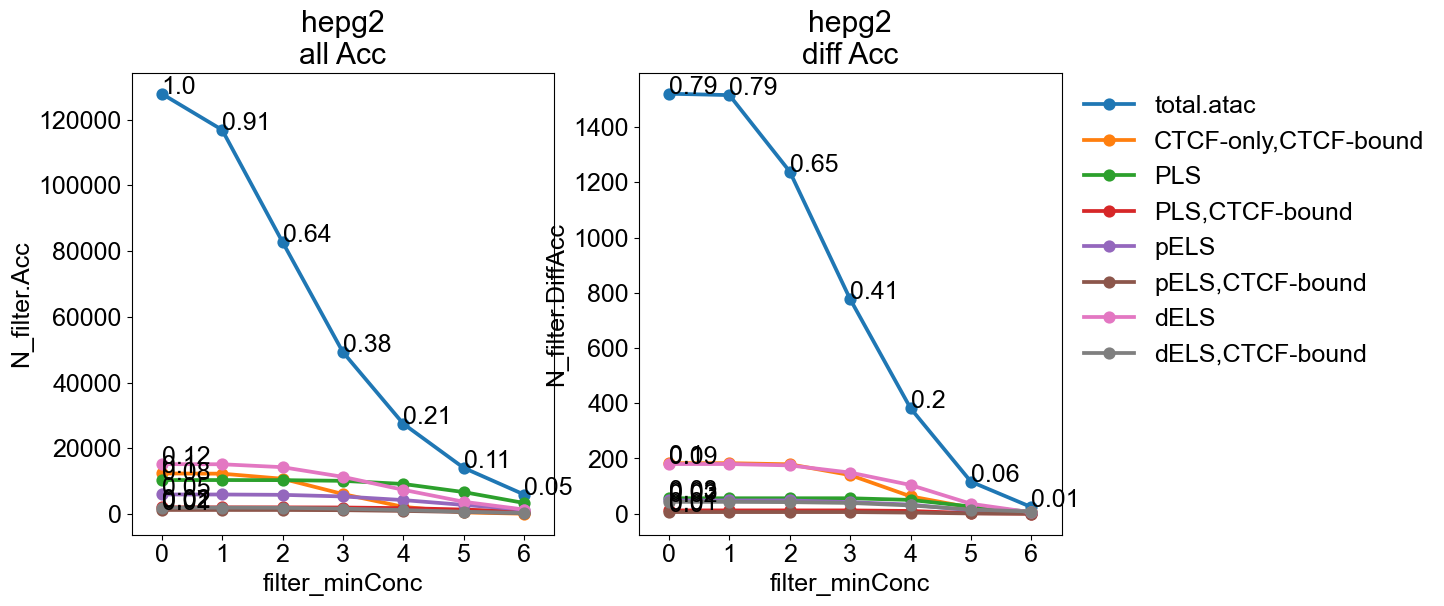

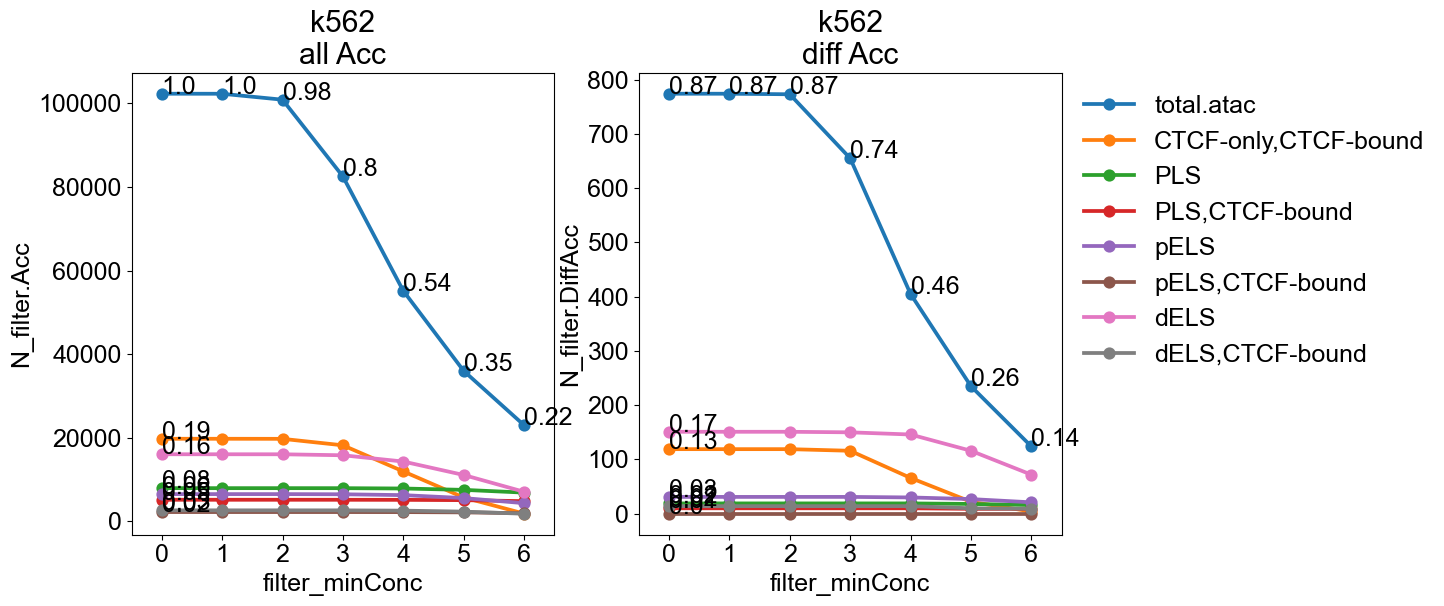

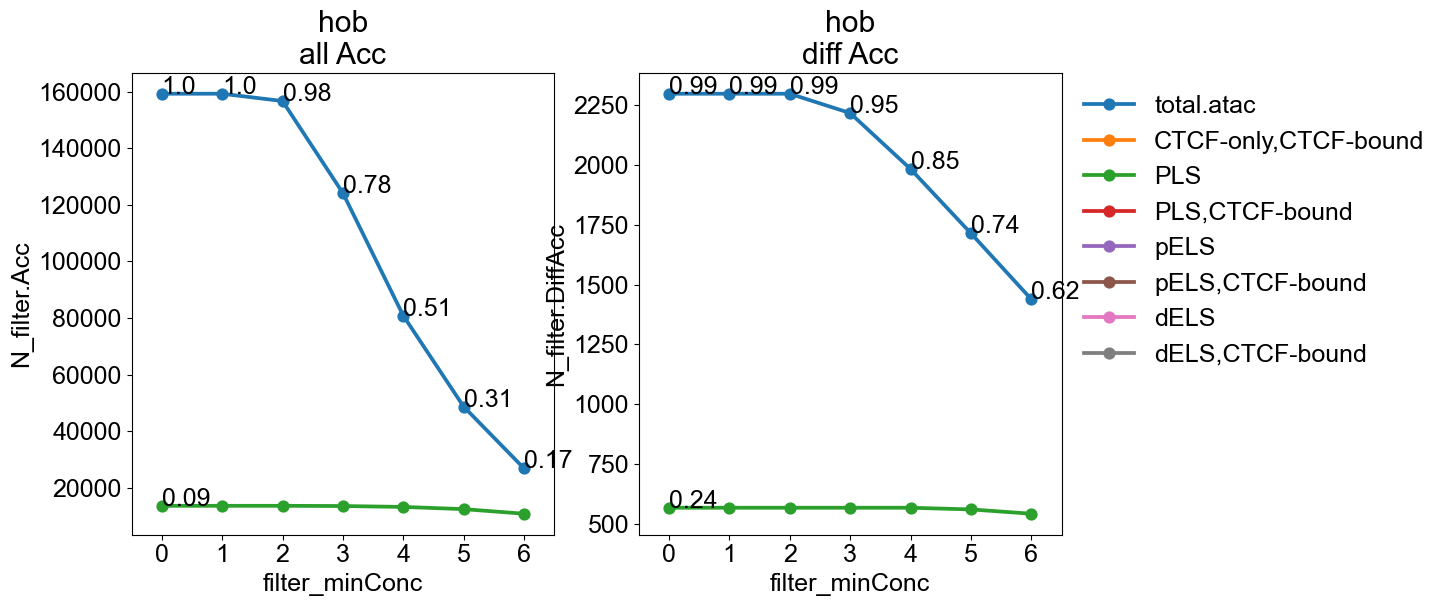

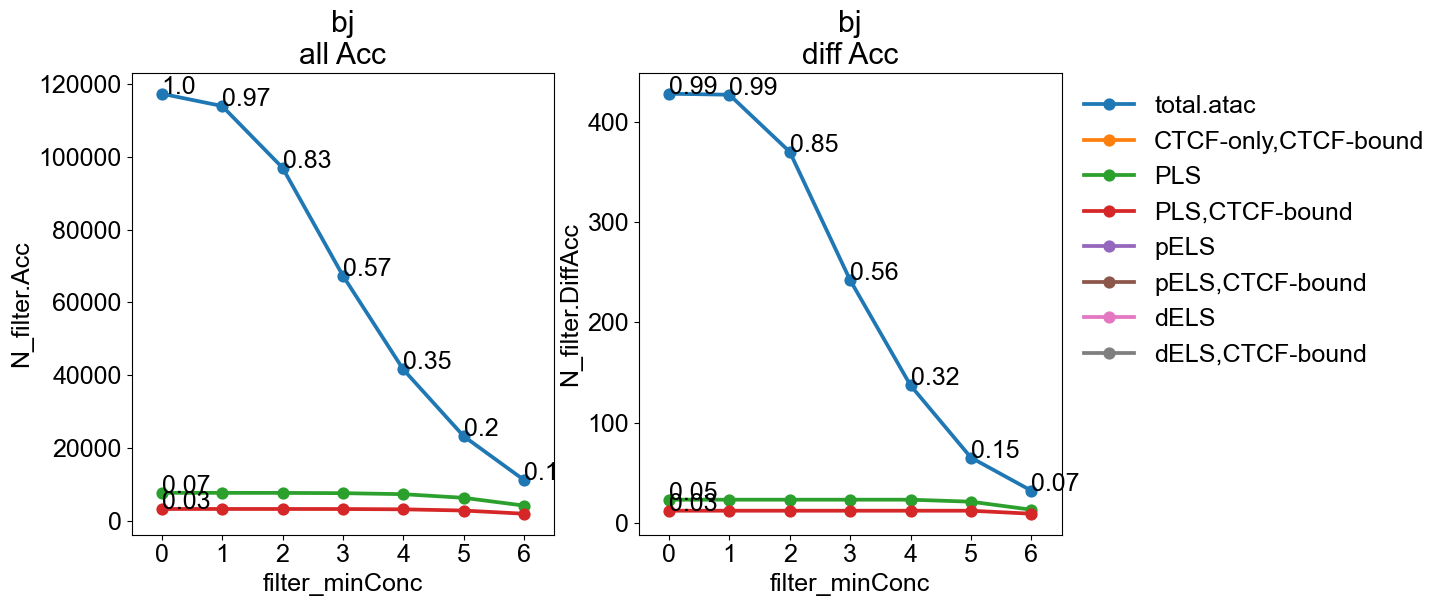

In [68]:
for CL in CLS:
    x = "filter_minConc"
    y = 'N_filter.Acc'
    hue = "annotation"
    hue_order = ['total.atac',
                 'CTCF-only,CTCF-bound',
                 'PLS',
                 'PLS,CTCF-bound',
                 'pELS',
                 'pELS,CTCF-bound',
                 'dELS',
                 'dELS,CTCF-bound',
                 ]
    data = results.loc[results["cl"] == CL]


    # plot
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.pointplot(x=x, y=y, data=data,
                  hue=hue, hue_order=hue_order,
                  ax=ax1)
    ax1.legend(frameon=False, bbox_to_anchor=(1, 1)).remove()
    ax1.set(title=f"{CL}\nall Acc",
            #ylim=(-0.1, 1.1)
            )
    for i,row in data.iterrows():
        plot_val = "percent_allAcc"
        if row[hue] == "total.atac":
            ax1.text(row[x], row[y],round(row[plot_val], 2))
        elif row[hue] != "total.atac" and int(row[x]) < 1:
            ax1.text(row[x], row[y],round(row[plot_val], 2))


    y = 'N_filter.DiffAcc'
    sns.pointplot(x=x, y=y, data=data,
                  hue=hue, hue_order=hue_order,
                  ax=ax2)
    ax2.legend(frameon=False, bbox_to_anchor=(1, 1))

    for i,row in data.iterrows():
        plot_val = "percent_DiffAcc"
        if row[hue] == "total.atac":
            ax2.text(row[x], row[y],round(row[plot_val], 2))
        elif row[hue] != "total.atac" and int(row[x]) < 1:
            ax2.text(row[x], row[y],round(row[plot_val], 2))
            
    ax2.set(title=f"{CL}\ndiff Acc",
            #ylim=(-0.1, 1.1)
            )

    out = os.path.join(RE, f"{CL}_x_cCRE_diffbind_deseq_atac_pct.pdf")
    plt.savefig(out, bbox_inches='tight')



# filtering results

In [74]:
cl_results['hepg2.4']

cl            annotation  filter_minConc   N_cCRE  N_filter.Acc  \
0  hepg2            total.atac               4      NaN         27452   
1  hepg2  CTCF-only,CTCF-bound               4  20944.0          2168   
2  hepg2                  dELS               4  25435.0          7354   
3  hepg2        PLS,CTCF-bound               4   2377.0          1778   
4  hepg2                  pELS               4  16656.0          4232   
5  hepg2                   PLS               4  13597.0          9134   
6  hepg2       pELS,CTCF-bound               4   2613.0           933   
7  hepg2       dELS,CTCF-bound               4   2947.0          1181   

   N_filter.DiffAcc  percent_allAcc  percent_DiffAcc  
0               382        0.213949         0.199374  
1                63        0.016896         0.032881  
2               104        0.057314         0.054280  
3                10        0.013857         0.005219  
4                33        0.032982         0.017223  
5                50        0.071186         0.026096  
6                 4        0.007271         0.002088  
7                30        0.009204         0.015658

In [69]:
results.loc[results["annotation"]=="total.atac"].round(2)

cl  annotation  filter_minConc  N_cCRE  N_filter.Acc  N_filter.DiffAcc  \
0  hepg2  total.atac               0     NaN        127857              1521   
0  hepg2  total.atac               1     NaN        116859              1516   
0  hepg2  total.atac               2     NaN         82757              1239   
0  hepg2  total.atac               3     NaN         49249               777   
0  hepg2  total.atac               4     NaN         27452               382   
0  hepg2  total.atac               5     NaN         14038               116   
0  hepg2  total.atac               6     NaN          5919                24   
0   k562  total.atac               0     NaN        102300               774   
0   k562  total.atac               1     NaN        102292               774   
0   k562  total.atac               2     NaN        100873               773   
0   k562  total.atac               3     NaN         82505               655   
0   k562  total.atac               4     NaN         55136               405   
0   k562  total.atac               5     NaN         35988               235   
0   k562  total.atac               6     NaN         22990               124   
0    hob  total.atac               0     NaN        159246              2299   
0    hob  total.atac               1     NaN        159243              2299   
0    hob  total.atac               2     NaN        156659              2299   
0    hob  total.atac               3     NaN        124148              2218   
0    hob  total.atac               4     NaN         80828              1984   
0    hob  total.atac               5     NaN         48679              1715   
0    hob  total.atac               6     NaN         26840              1439   
0     bj  total.atac               0     NaN        117245               428   
0     bj  total.atac               1     NaN        113870               427   
0     bj  total.atac               2     NaN         96945               370   
0     bj  total.atac               3     NaN         67339               242   
0     bj  total.atac               4     NaN         41612               137   
0     bj  total.atac               5     NaN         23307                65   
0     bj  total.atac               6     NaN         11283                32   

   percent_allAcc  percent_DiffAcc  
0            1.00             0.79  
0            0.91             0.79  
0            0.64             0.65  
0            0.38             0.41  
0            0.21             0.20  
0            0.11             0.06  
0            0.05             0.01  
0            1.00             0.87  
0            1.00             0.87  
0            0.98             0.87  
0            0.80             0.74  
0            0.54             0.46  
0            0.35             0.26  
0            0.22             0.14  
0            1.00             0.99  
0            1.00             0.99  
0            0.98             0.99  
0            0.78             0.95  
0            0.51             0.85  
0            0.31             0.74  
0            0.17             0.62  
0            1.00             0.99  
0            0.97             0.99  
0            0.83             0.85  
0            0.57             0.56  
0            0.35             0.32  
0            0.20             0.15  
0            0.10             0.07

In [17]:
results.loc[results["annotation"].str.contains("LS")].sort_values(by="annotation").round(2)

cl       annotation  filter_minConc   N_cCRE  N_filter.Acc  \
2      bj              PLS               6   9445.0          4269   
1     hob              PLS               5  18798.0         12465   
1     hob              PLS               4  18798.0         13242   
1     hob              PLS               3  18798.0         13560   
5   hepg2              PLS               4  13597.0          9134   
..    ...              ...             ...      ...           ...   
1    k562  pELS,CTCF-bound               2   6580.0          2207   
1    k562  pELS,CTCF-bound               6   6580.0          1917   
6   hepg2  pELS,CTCF-bound               6   2613.0           295   
6   hepg2  pELS,CTCF-bound               2   2613.0          1219   
6   hepg2  pELS,CTCF-bound               5   2613.0           594   

    N_filter.DiffAcc  percent_allAcc  percent_DiffAcc  
2                 13            0.04             0.03  
1                560            0.08             0.24  
1                567            0.08             0.24  
1                567            0.08             0.24  
5                 50            0.07             0.03  
..               ...             ...              ...  
1                  0            0.02             0.00  
1                  0            0.02             0.00  
6                  0            0.00             0.00  
6                  6            0.01             0.00  
6                  1            0.00             0.00  

[105 rows x 8 columns]

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
values = pd.merge(ctrl[["coor", "rep1", "rep2", ]], us[["rep1", "rep2", "coor"]], left_on="coor", right_on="coor")
values

In [ ]:
X = values[["rep1_x", "rep2_x", "rep1_y", "rep2_y"]]#.pivot(columns = 'coor', values=['rep1', 'rep2'])

In [ ]:
pca = PCA(n_components=4)
X_ = pca.fit_transform(X)

print(pca.explained_variance_ratio_) 

In [ ]:
X_